# Gaussian Process Regression (in 1-D)

Gaussian processes belong to class of non-parametric regression models in machine learning. To try and develop an understanding of what is meant by "non-parametric" in this context, let's consider as an example the modelling of a star's photometric variability as shown below.

In [86]:
import matplotlib.image as mpimg
import pylab as plt
import numpy as np
%matplotlib inline

(<matplotlib.text.Text at 0x11f479f90>,
 (-10, 543.49337700009346),
 (0.02, -0.02))

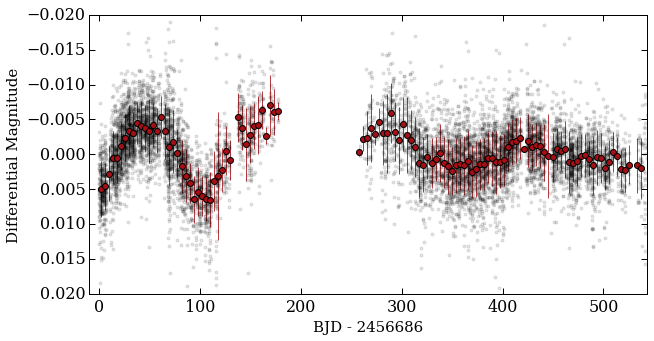

In [87]:
# Plot the (binned) photometric light curve
from MEarthphotometry import *   # custom class
self = loadpickle('MEarthphot')
t, y, ey = self.bjdtrimbin, self.magtrimbin, self.emagtrimbin
# Plotting
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
t0 = round(min(self.bjd))
ax.plot(self.bjdtrim-t0, self.magtrim, 'k.', alpha=.1)
ax.errorbar(t-t0, y, ey, fmt='o', color='#a50f15', capsize=0, elinewidth=.8)
plt.gca().invert_yaxis()
ax.set_xlabel('BJD - %i'%t0), ax.set_ylabel('Differential Magnitude'), ax.set_xlim((-10,max(self.modelbjd)-t0)), ax.set_ylim((.02,-.02))

## Why use GP regression?: parametric models aren't always complete
In the frequentist approach, one may assume a functional form of the model to the dataset. 
Once the best-fit parameters of that model have been optimized, the model can be used to *predict* the values of $y_i$ at previously unseen epochs $t_i$. Recall that this is the primary goal of regression modelling in machine learning. In the above example, the brightness variations appear roughly periodic in time so we might be tempted to model the light curve with a purely sinusoidal function of the form

\begin{equation}
\Psi_i = A \sin{\left( \frac{2\pi t_i}{P_{\text{rot}}} + \phi \right)}.
\end{equation}

With this optimized model we can estimate the probability of obtaining certain values of the star’s brightness $\Psi_i$ the next time we go back to our telescope to observe the star by evaluating the model at those previously unseen epochs. This is great! We’ve obtained a model that we can use for predictive purposes! However, we have assumed a functional form of the model which itself can be thought of as a hyperparameter of the model to the dataset. Indeed this model may not be complete you may suspect to have been the case in this example given that the stellar photometric variability does not appear to be purely sinusoidal (i.e. the decaying photometric amplitude with time). Effects of the varying lifetimes, contrast, and spatial distribution of active regions on the stellar surface over adjacent rotation cycles may result in brightness variations which are not strictly periodic. **In this case a purely sinusoidal function clearly does not completely capture the structure present in the star’s light curve and we should pursue a more complete model.**

## Why use GP regression?: advantages of non-parametricity (is that a real word?)

An alternative approach is to assign a prior probability to *every possible function* that could potentially model our photometric timeseries. We’ll call this the Bayesian approach because it incorporates our prior knowledge of what can reasonably model our (training) dataset and potentially any unseen data. But computational restrictions dictate that we cannot possibly evaluate *every possible function*. Instead, we can use a Gaussian process (GP) to model the covariance between each individual datapoint with every other.

GP regression is a method of supervised learning wherein the covariance properties of the input dataset are described by a set of hyperparameters which are trained on the data itself. But what is the GP? The GP, with its optimized set of hyperparameters, is itself a **multivariate Gaussian distribution** of dimension $N$ where $N$ is the number of datapoints in the training set. Therefore the evaluation of the model at each epoch $t_i$ is not deterministic but instead is a 1D Gaussian distribution (also called the predictive distribution) whose mean value gives us the *most-likely* model prediction $\Psi(t_i)$. Because we do not consider a specific functional form of the model to the data as we did previously by modelling the star's photometric variations with a sinusoidal function, the GP regression model is called non-parametric. It implies that the 'shape' of the model is dictated by the data itself but whose covariance properties are described by some chosen prior regarding how the data are correlated with each other. **The advantage of non-parametric modelling is that it allows us to make fewer prior assumptions regarding the functional form of a model to our timseries thus giving much more freedom to the model.**

Returning now to our example of the varying stellar brightness, below I've plotted an optimized *mean* GP regression model and its 95% confidence intervals to illustrate the nature of the model as being non-parametic. Soon we'll discuss how to obtain this GP model in practice.

(<matplotlib.text.Text at 0x11fbee250>,
 (-10, 543.49337700009346),
 (0.02, -0.02))

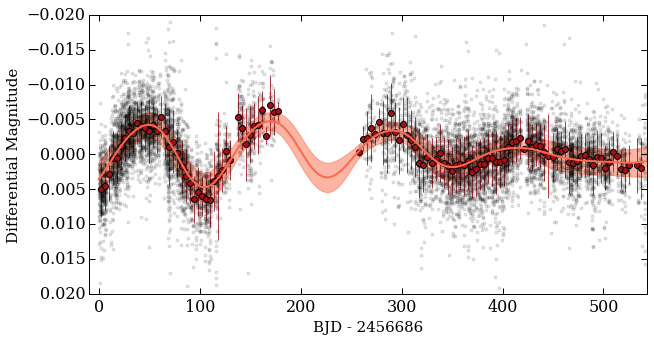

In [88]:
# Plotting
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
t0 = round(min(self.bjd))
ax.plot(self.bjdtrim-t0, self.magtrim, 'k.', alpha=.1)
ax.errorbar(t-t0, y, ey, fmt='o', color='#a50f15', capsize=0, elinewidth=.8)
ax.plot(self.modelbjd-t0, self.model, '-', c='#fb6a4a', lw=2)
ax.fill_between(self.modelbjd-t0, self.model-2*self.modelerr, self.model+2*self.modelerr, color='#fb6a4a', alpha=.5)
plt.gca().invert_yaxis()
ax.set_xlabel('BJD - %i'%t0), ax.set_ylabel('Differential Magnitude'), ax.set_xlim((-10,max(self.modelbjd)-t0)), ax.set_ylim((.02,-.02))

## The formalism (i.e. the math)
Okay so we've said a lot about what GP regression is and why it can be useful but let's now turn to some mathematical background.

We said that the GP model is a multivariate Gaussian distribution of dimension $N$ where $N$ is the number of datapoints in the timeseries. Therefore the evaluation of the model at time $t_i$ is a Gaussian distribution which of course has a well-defined mean and variance. In fact, this is the definition of a GP.

**Definition:** a GP on any set $T$ is a set of random variables such that $\forall t_1,\cdots,t_N$ in $T$, the vector $M = (M_1,\cdots,M_N)$ is a multivariate Gaussian. 

Or,

a GP is any set of random variables for which any finite subset are Gaussian distributed. Being mutivariate, a GP can be thought of as **the probability of obtaining a model to a dataset or a Gaussian distribution of functions.**

There are fancy theorems regarding the existance of GPs but the only important take-away for our purposes is that for *any* set $T$ (like our array of observation epochs), *any* real-valued mean function $\mu(t)$, and *any* real-valued covariance function $k(t,t')$, there exists a GP on $T$ with expection value $=\mu(t)$ and cov$(M_s,M_t)=k(s,t)$. Basically, **we can always construct a valid GP to describe a timeseries with appropriately chosen mean and covariance functions.**

# Computing our GP model (in python)
I'll quickly introduce the code that I use most often as it's not part of sklearn although sklearn does have (some) capabilities. The python library is called george (http://dan.iel.fm/george/current/). The library contains functions to perform tasks such as GP definition and computation as well as sampling from your GP. We'll see its implementation as we progress towards computing the GP model shown in the figure above. 


## Mean functions
Recall that a unique GP on the set of observation epochs $T=(t_1,\cdots,t_N)$ is specified by a mean function $\mu(t)$ and covariance function $k(t,t')$ describing how the stellar brightness at time $t$ is correlated with the stellar brightness at time $t'$. The mean function is used to 'zero-out' the timeseries such that the GP only acts to model the correlated residuals. For example, in the case of radial velocity observations of a single-planetary system which is also contaminated with stellar jitter, the mean function would be the keplarian signal of the planet and the GP would be used to model the correlated noise arising from jitter; i.e. star spots, granulation, etc. This specification of the mean function in **george** is not done explicitly. Instead it is expected that the dataset minus the mean function be specified when initializing a GP with george (the GP object).

## Covariance functions
Initializing the GP does require that we specify the covariance kernel or the way in which the data in our training set are correlated. There are many valid covarince functions to choose from. Some of the most popular ones are included in the george kernel library (see http://dan.iel.fm/george/current/user/kernels). 

In [89]:
import george
from george import kernels
# uncomment below to read about some popular built-in covariance kernels
#help(kernels.WhiteKernel)
#help(kernels.ExpSquaredKernel)
#help(kernels.Matern32Kernel)
#help(kernels.ExpSine2Kernel)

In addition to the kernels specified above, additional more complicated kernels can constructed via the linear combination of multiple kernel functions. This is the adopted case for the stellar photometric variability. Namely we have rotationally modulated jitter arising from surface inhomogenities on the star such as cool spots and/or bright plages in the star's chromosphere. The data's correlation is therefore expected to have a periodic component at the stellar rotation period ($P_{\text{rot}}$). However, higher order effects such as the varying lifetimes, contrast, and spatial distribution of active regions will cause the correlations to instead be *quasi-periodic*. This covariance kernel can commonly constructed via the superposition of the squared exponential kernel 

\begin{equation}
k(t,t') = \exp{\left( -\frac{(t-t')^2}{2 \lambda^2} \right)}
\end{equation}

and the periodic covariance kernel

\begin{equation}
k(t,t') = \exp{\left( -\Gamma^2 \sin^2{\left[ \frac{\pi |t-t'|}{P} \right]} \right)}.
\end{equation}

Together the quasi-periodic covariance kernel (with amplitude $a$) is

\begin{equation}
k(t,t') = a^2 \exp{\left( -\frac{(t-t')^2}{2 \lambda^2} -\Gamma^2 \sin^2{\left[ \frac{\pi |t-t'|}{P} \right]} \right)}.
\end{equation}

The quasi-periodic covariance kernel therefore has a set of four hyperparameters $\theta=(a,\lambda,\Gamma,P)$ where $a$ is the amplitude of the correlations, $\lambda$ is the exponentially decaying timescale (i.e. measurements further away from each other in time are less correlated than those that are close together), $\Gamma$ is this weird 'coherence' scale, and $P$ is the periodicity of the periodic component ($P=P_{\text{rot}}$ in the photometric light curve). See http://dan.iel.fm/gp.js/ to play with the effect of varying the hyperparameter values. For the quasi-periodic kernel at the aforementioned link, the order of the hyperparameter sliders is $a,\Gamma,P,\lambda$.

Using the optimized hyperparameters from my previous analysis of the above light curve, we can initialize our quasi-periodic GP with george via

In [90]:
# hyperparameters for the GJ 1132 light curve
a, l, G, Prot = 1.439e-5, 6.522e4, 6.883e-1, 1.224e2
my_gp = george.GP(a * (kernels.ExpSquaredKernel(l) * kernels.ExpSine2Kernel(G, Prot)))

We can now compute the covariance matrix $K$ from our kernel $k$ and photometric measurement errors $\sigma_i$ via

\begin{equation}
K_{ij} = \sigma_i^2 \delta_{ij} + k(t_i,t_j),
\end{equation}

where $\delta_{ij}$ is the Kronecker delta function. 

Next we can compute the covariance matrix given the independent variable $t$ and measurement errors. We can then visualize our covariance matrix.

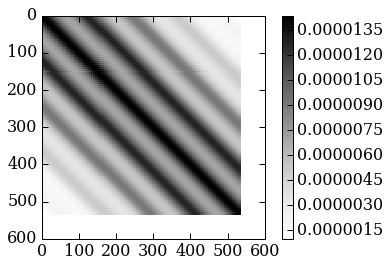

(<matplotlib.colorbar.Colorbar at 0x1194862d0>, None, None, None)

In [91]:
my_gp.compute(t, ey)  # matrix needs to know the times and values of the diagonal elements
# Plotting
tm = np.linspace(t.min(),t.max(),1e2) - t.min()
plt.pcolormesh(tm, tm, my_gp.get_matrix(tm), cmap=plt.get_cmap('Greys'))
plt.colorbar(), plt.axes().set_aspect('equal'), plt.gca().invert_yaxis(), plt.show()

Now that we have specified the covariance matrix, we can draw samples from the GP prior function (using george.GP.sample). Remember that the GP is an $N$ dimensional multivariate Gaussian whose covariance is desribed by $K$. So despite us randomly sampling from a Gaussian distribution at each $t_i$, the resulting regression model will still be smooth.

(<matplotlib.text.Text at 0x11fbe6790>,
 (-10, 543.49337700009346),
 (0.015, -0.015))

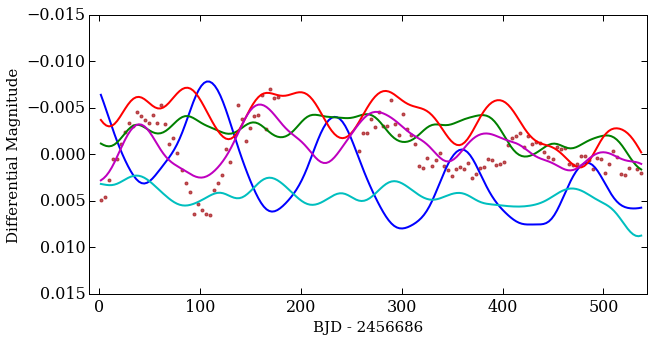

In [92]:
# Plotting prior samples
Nsamples = 5
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
t0 = round(min(self.bjd))
ax.plot(t-t0, y, '.', c='#a50f15', alpha=.7)
tm = np.linspace(t.min(), t.max(), 2e2)
for i in range(Nsamples):
    ax.plot(tm-t0, my_gp.sample(tm), '-')
plt.gca().invert_yaxis()
ax.set_xlabel('BJD - %i'%t0), ax.set_ylabel('Differential Magnitude'), ax.set_xlim((-10,max(self.modelbjd)-t0)), ax.set_ylim((.015,-.015))

We haven't told the GP about our data yet so the samples from the prior do not trace the observations but they do exhibit the expected covariance properties. Namely, smooth evolution (small $\Gamma$) with a distinct periodicity ($P\sim 122$ days) and a long timescale decay in amplitude ($\lambda \sim 6.5 \times 10^4$ days).


## Conditioning the GP on the data
We can compute the posterior function (up to a constant) from which to sample given the input dataset and the likelihood function. Recall from Baye's theorem that 

\begin{equation}
\ln{\text{posterior}} \propto \ln{\text{prior}} + \ln{\text{likelihood}}.
\end{equation}

For a GP with specified mean function $\boldsymbol{\mu}$ and covariance matrix $K$, the logarithmic likelihood function for the data $\mathbf{y}$ can be computed analytically via

\begin{equation}
\ln{\mathcal{L}} = -\frac{1}{2} \left( \mathbf{r}^T K^{-1} \mathbf{r} + \ln{\mathrm{det} K} + N \ln{2 \pi} \right),
\end{equation}

where $\mathbf{r} \equiv \mathbf{y} - \boldsymbol{\mu}$ is the residual vector. For our fiducial light curve in differential magnitudes, the data are already centered at zero so we take $\boldsymbol{\mu}$ to be the zero vector.

With the values of $\theta$ specified, we can compute the predictive posterior mean $M$ and covariance $C$ at epochs $t'$ via

\begin{align}
M &= K(t'_i, t_j) K(t_i,t_j)^{-1} y(t_j), \\
C &= K(t'_i,t*_j) - K(t'_i, t_j) K(t_i,t_j)^{-1} K(t'_i, t_j)^T
\end{align}

and consequently sample from the predictive posterior distribution. However we are often most interested in the predictive mean (maximum a-posteriori model) and its variance (confidence intervals) at previously unseen epochs $t'$. 

In [93]:
tprime = np.linspace(t.min(), t.max(), 2e2)
M, C = my_gp.predict(y, tprime)  # give data to evaluate likelihood at prediction epochs tprime
sig = np.sqrt(np.diag(C))

(<matplotlib.text.Text at 0x120015050>,
 (-10, 543.49337700009346),
 (0.015, -0.015))

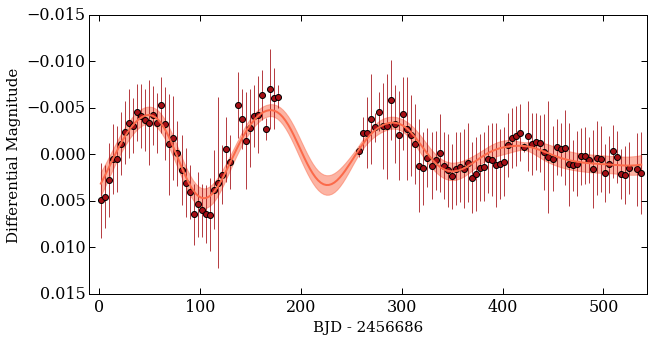

In [94]:
# Plotting posterior mean and one standard deviation
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
t0 = round(min(self.bjd))
ax.errorbar(t-t0, y, ey, fmt='o', color='#a50f15', capsize=0, elinewidth=.8)
ax.plot(tprime-t0, M, '-', c='#fb6a4a', lw=2)
ax.fill_between(tprime-t0, M-sig, M+sig, color='#fb6a4a', alpha=.5)
plt.gca().invert_yaxis()
ax.set_xlabel('BJD - %i'%t0), ax.set_ylabel('Differential Magnitude'), ax.set_xlim((-10,max(self.modelbjd)-t0)), ax.set_ylim((.015,-.015))

Note that the GP predictive model is well-constrained where there exists training data. At epochs far from the epochs in the training set $T=t_1,\cdots,t_N$, the covariance properties still constrain the predictive mean but the model variance becomes understandably large. 

(<matplotlib.text.Text at 0x12036e150>,
 (-698.43885299982503, 1237.561147000175),
 (0.015, -0.015))

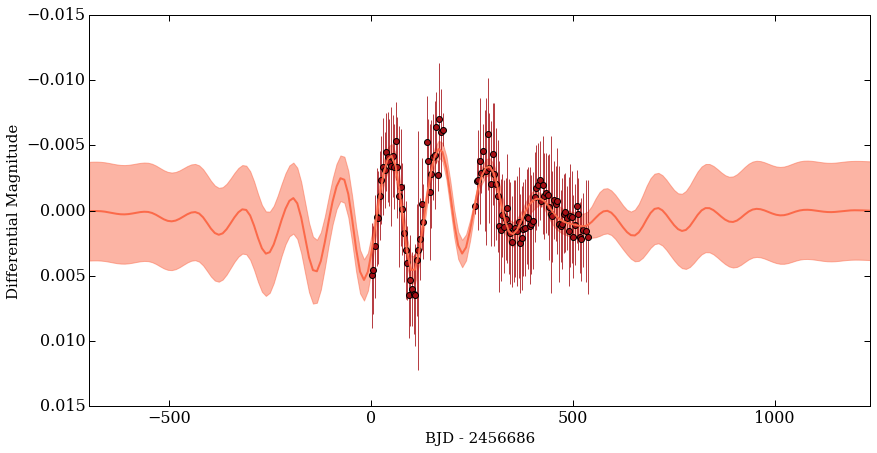

In [95]:
tprime_out = np.linspace(t.min()-700, t.max()+700, 2e2)
M_out, C_out = my_gp.predict(y, tprime_out)
sig_out = np.sqrt(np.diag(C_out))
# Plotting posterior mean and one standard deviation
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
t0 = round(min(self.bjd))
ax.errorbar(t-t0, y, ey, fmt='o', color='#a50f15', capsize=0, elinewidth=.8)
ax.plot(tprime_out-t0, M_out, '-', c='#fb6a4a', lw=2)
ax.fill_between(tprime_out-t0, M_out-sig_out, M_out+sig_out, color='#fb6a4a', alpha=.5)
plt.gca().invert_yaxis()
ax.set_xlabel('BJD - %i'%t0), ax.set_ylabel('Differential Magnitude'), ax.set_xlim((tprime_out.min()-t0,tprime_out.max()-t0)), ax.set_ylim((.015,-.015))

## Optimizing the hyperparameters
The first method of GP hyperparmeter optimization is just likelihood maximization and is built-in to george via the scipy.stats.optimize function. This method is admittedly not very robust. Let's compare our previously adopted hyperparameter values to those obtained from the built-in likelihood maximization routine.

In [96]:
theta_orig = my_gp.kernel.pars
# create a second GP with non-optimized parameters
theta_nonopt = my_gp.kernel.pars * np.random.uniform(.5, 1.5, 4)
a, l, G, Prot = theta_nonopt
my_2nd_gp = george.GP(a * (kernels.ExpSquaredKernel(l) * kernels.ExpSine2Kernel(G, Prot)))
# Optimize these hyperparameters
success = False
while not success:
    theta_opt, results = my_2nd_gp.optimize(t, y, ey)
    success = results['success']
labels = ['a','l','G','P']
for i in range(4):
    print '\n%s:'%labels[i]
    print 'Non-optimized %s = %.3e'%(labels[i], theta_nonopt[i])
    print 'Optimized %s = %.3e'%(labels[i], np.exp(theta_opt[i]))
    print 'Original %s = %.3e'%(labels[i], theta_orig[i])

Optimization terminated successfully.

a:
Non-optimized a = 2.147e-05
Optimized a = 1.050e-05
Original a = 1.439e-05

l:
Non-optimized l = 5.486e+04
Optimized l = 6.715e+04
Original l = 6.522e+04

G:
Non-optimized G = 7.433e-01
Optimized G = 8.970e-01
Original G = 6.883e-01

P:
Non-optimized P = 1.197e+02
Optimized P = 1.220e+02
Original P = 1.224e+02


Run the above cell a few times. The optimal hyperparameters tend to vary sometimes by orders of magnitude (i.e. P).

Another common method is to use MCMC sampling the obtain a maximum a posteriori estimate of the hyperparameter values and their uncertainies. To do so one must evaulate the ln likelihood function at each step in their MCMC chain which requires a matrix inversion operation. George has a built-in method to compute the inverse of the covariance matrix via Cholesky decomposition. We can therefore fold the lnlikehood method into our own MCMC code for a given set of sampled hyperparameter values $\theta'$. Note that the dependent variable must already be corrected by the mean function; i.e. feed the residual vector ($\textbf{r} \equiv \textbf{y} - \boldsymbol{\mu}$) to george.  

In [97]:
# example of computing the likelihood
thetaprime = my_gp.kernel.pars * np.random.uniform(.9, 1.1, 4)
a, l, G, Prot = thetaprime
my_3rd_gp = george.GP(a * (kernels.ExpSquaredKernel(l) * kernels.ExpSine2Kernel(G, Prot)))
my_3rd_gp.compute(t, ey)
mean_func = np.zeros(t.size)    # our mean function is zero
lnl = my_3rd_gp.lnlikelihood(y - mean_func)
# put the above code into your lnlikelihood function which is called at each step in your MCMC chain

Other (untested) methods of hyperparmeter estimation may include cross-validation.

## Notes on computing the likelihood.
The computational complexity of computing the $K$ matrix inverse is typically $\mathcal{O}(N^3)$. Therefore the calculation quickly becomes cumbersome for very large datasets such as the unbinned photometry in our fiducial light curve ($N=9039$). From this argument it becomes obvious why we binned the photometric data ($N=114$) when computing our GP regression model of the light curve. However the fast GP code george is able to reduce this to $\mathcal{O}(N\log{2N})$.

## Final notes
Another illustrative example can be found here: http://dan.iel.fm/george/current/user/model/ which includes the python steps required to implement GP regression modelling into the emcee (http://dan.iel.fm/emcee/current/) MCMC package. This is something that I've found incredibly useful in my own research and am happy to discuss it with you all further.

cloutier@astro.utoronto.ca